In [1588]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

file_path = '/Users/miked/Documents/Travel_Tide_Project/FinalizedTravelTideSQL.csv'

df = pd.read_csv(file_path)

df.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration,...,avg_flight_seats,avg_checked_bags,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,avg_flight_distance_from_home_km,weekend_trip_proportion
0,167852,2022-05-03,17,F,False,False,usa,tampa,13,0.85,...,NaN,NaN,0,NaN,0.10,0.31,NaN,NaN,NaN,0.0
1,181157,2022-05-15,53,F,True,False,usa,houston,10,1.90,...,2.00,1.00,4,139.40,0.15,0.20,1.60,6.00,5773.40,0.0
2,252835,2022-07-18,37,F,False,True,usa,chicago,14,3.29,...,1.10,0.80,7,133.50,0.05,0.14,1.13,2.38,1569.44,0.0
3,283325,2022-08-12,50,F,True,False,usa,dallas,13,1.38,...,1.00,0.50,5,222.80,0.08,0.15,1.20,1.80,2074.38,0.2
4,299476,2022-08-25,38,F,True,False,usa,atlanta,13,2.54,...,1.25,0.25,3,364.75,0.12,0.31,1.00,3.25,4109.35,0.0


In [1589]:
df.shape

(5998, 31)

In [1590]:
missing_values = df.isnull().sum()
missing_values

user_id                                0
sign_up_date                           0
age                                    0
gender                                 0
married                                0
has_children                           0
home_country                           0
home_city                              0
session_count                          0
avg_session_duration                   0
avg_page_clicks                        0
total_trips                            0
conversion_rate                        0
cancellation_proportion              432
avg_days_depatrure_book              792
avg_days_checkin_book                563
total_flights_booked                   0
avg_flight_price_usd                 792
avg_flight_discount_amount          1277
discounted_flight_proportion           0
round_trips_proportion                 0
avg_flight_seats                     792
avg_checked_bags                     792
total_hotels_booked                    0
avg_hotel_price_

In [1591]:
# Checking users who haven't cancelled
df['has_booked'] = ~df['cancellation_proportion'].isna()

# filling cancellation_proportion column null values with 0
df['cancellation_proportion'].fillna(0, inplace=True)

In [1592]:
# Determine the position to insert the new column after the last_min_booking columns
position = df.columns.get_loc('avg_days_checkin_book') + 1

# Insert the new column which is the maximum of the both columns at the desired position
df.insert(position, 'avg_booking_departure_days', 
            df[['avg_days_depatrure_book', 'avg_days_checkin_book']].max(axis=1))

# Drop the original columns
df.drop(columns=['avg_days_depatrure_book', 'avg_days_checkin_book'], inplace=True)

# check the number of null values of the new column 'avg_booking_departure_days'
null_values = df['avg_booking_departure_days'].isna().sum()
print(f'{null_values} null values in avg_booking_departure_days column.')

432 null values in avg_booking_departure_days column.


In [1593]:
max_gap = df['avg_booking_departure_days'].max()
df['avg_booking_departure_days'].fillna(max_gap, inplace=True)

In [1594]:
# Checking users who haven't booked a flight
df['has_booked_flight'] = ~df['avg_flight_price_usd'].isna()

# Columns to fill with 0
columns_to_fill_0 = ['avg_flight_discount_amount', 'avg_flight_seats', 'avg_checked_bags']

# Columns to fill with their medians
columns_to_fill_median = ['avg_flight_price_usd']

# filling null values with zero
for col in columns_to_fill_0:
    df[col].fillna(0, inplace=True)

# filling null values with median
for col in columns_to_fill_median:
    df[col].fillna(df[col].median(), inplace=True)

In [1595]:
# Check haven't booked a hotel
df['has_booked_hotel'] = ~df['avg_hotel_price_usd'].isna()

# Columns to fill with 0
columns_to_fill_0 = ['avg_hotel_discount_amount', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Columns to fill with their medians
columns_to_fill_median = ['avg_hotel_price_usd', 'avg_flight_distance_from_home_km']

# filling null values with zero
for col in columns_to_fill_0:
    df[col].fillna(0, inplace=True)

# filling null values with median
for col in columns_to_fill_median:
    df[col].fillna(df[col].median(), inplace=True)

In [1596]:
# checking the number of null values
null_values = df.isna().sum().sum()
null_values

0

In [1597]:
df.describe()

,user_id,age,session_count,avg_session_duration,avg_page_clicks,total_trips,conversion_rate,cancellation_proportion,avg_booking_departure_days,total_flights_booked,...,avg_flight_seats,avg_checked_bags,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,avg_flight_distance_from_home_km,weekend_trip_proportion
count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,...,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000
mean,545440.695565,41.046182,8.427309,1.663418,17.641210,2.805435,0.333846,0.044105,45.365957,2.397966,...,1.056856,0.520340,2.527509,176.934353,0.076170,0.139868,1.085725,3.434386,2427.244910,0.049298
std,64924.749760,12.049037,0.790536,1.129033,8.566087,1.589629,0.185690,0.154708,98.812350,1.577156,...,0.578139,0.506341,1.511832,80.368540,0.068846,0.120533,0.482134,3.035244,2065.273359,0.137947
min,23557.000000,16.000000,8.000000,0.000000,4.130000,0.000000,0.000000,0.000000,1.500000,0.000000,...,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,-1.000000,27.450000,0.000000
25%,517152.000000,34.000000,8.000000,1.100000,12.560000,2.000000,0.220000,0.000000,7.010000,1.000000,...,1.000000,0.000000,1.000000,128.062500,0.000000,0.000000,1.000000,1.500000,1587.795000,0.000000
50%,540542.000000,41.000000,8.000000,1.440000,15.630000,3.000000,0.330000,0.000000,8.240000,2.000000,...,1.000000,0.500000,2.000000,163.400000,0.080000,0.130000,1.000000,2.750000,2050.870000,0.000000
75%,574146.000000,48.000000,9.000000,1.890000,19.750000,4.000000,0.500000,0.000000,10.610000,3.000000,...,1.250000,1.000000,4.000000,205.247500,0.100000,0.250000,1.250000,4.500000,2606.412500,0.000000
max,844489.000000,88.000000,14.000000,11.600000,109.130000,9.000000,1.000000,1.000000,365.080000,9.000000,...,6.000000,5.670000,8.000000,1063.000000,0.450000,0.750000,4.000000,30.000000,23057.330000,1.000000


In [1598]:
# replacing negative avg_stay_duration_day with 0
df.loc[df['avg_stay_duration_day'] < 0, 'avg_stay_duration_day'] = 0

negative_numbers = df[df['avg_stay_duration_day'] < 0].shape[0]

- Setting the threshold for outliers at 5 standard deviations away from the mean. Sturges' formula to calculate the bins to avoid a fixed number for bins. 

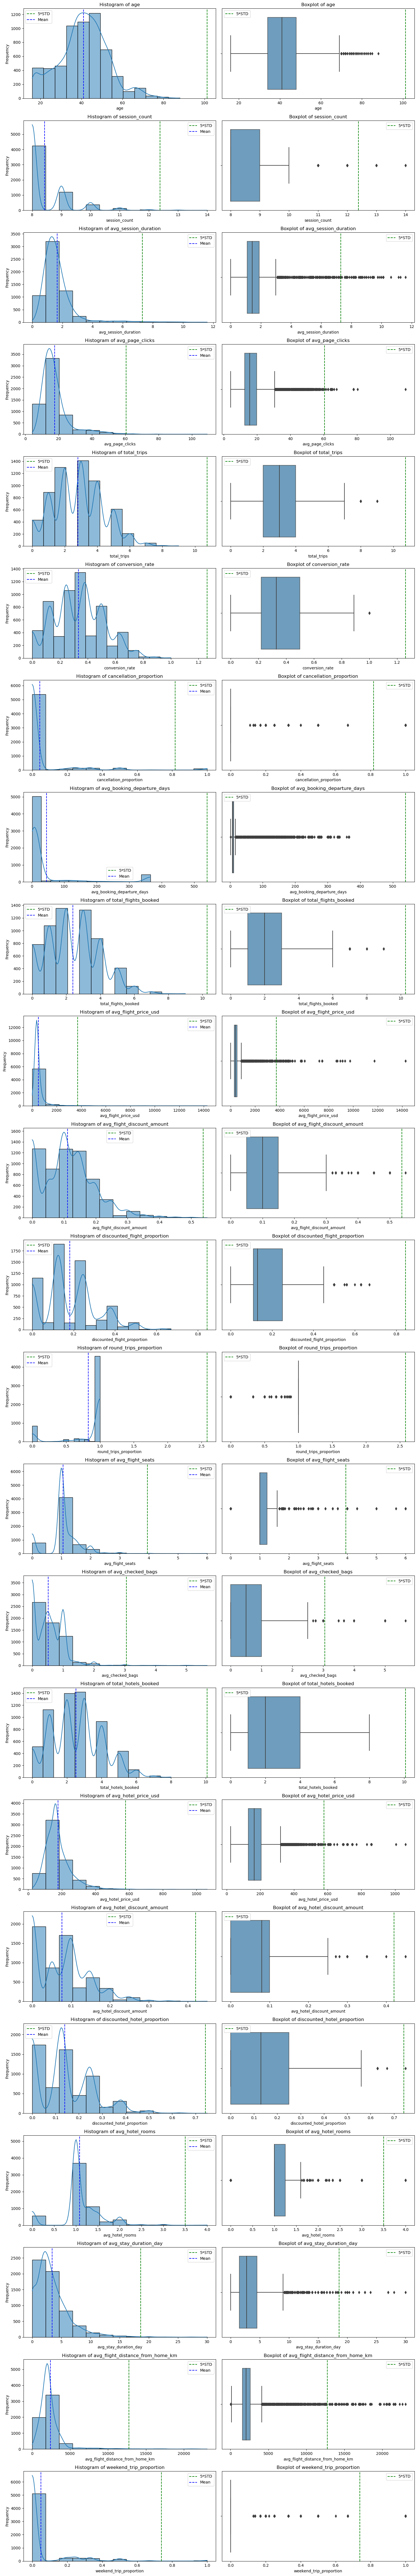

In [1599]:
# Select only numerical columns and excluding the user_id column
numerical_columns = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']


# Set up the figure and axes
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(15, 4 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    upper_bound = df[col].mean() + 5 * df[col].std()
    mean = df[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(df[col])) + 1)  # Sturges' formula
    sns.histplot(df[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD') # 5*STD line on boxplot
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=df[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    axes[i, 1].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD')  # 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

- All values over 5*STD is likely an outlier. 
- Some metrics have many values over the threshold 

In [1600]:
# Select only numerical columns, excluding 'user_id'
numerical_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Initialize a mask with all True values
mask = pd.Series([True] * len(df))

# Calculate the absolute Z-scores
adjusted_z_scores = np.abs(stats.zscore(df[numerical_cols]))

# Convert the Z-scores to a DataFrame with the same column names
z_scores_df = pd.DataFrame(adjusted_z_scores, columns=numerical_cols)

# Update the mask for each column
for col in numerical_cols:
    column_mask = (z_scores_df[col] < 5)
    mask &= column_mask

# Filter the data using the combined mask
data_no_outliers_adjusted = df[mask]

# Check the shape of the new DataFrame without outliers
new_shape_adjusted = data_no_outliers_adjusted.shape

# Count outliers per column
adjusted_outliers_count_per_col = (~mask).sum()

print(f'{adjusted_outliers_count_per_col} outliers.')

print(f'{new_shape_adjusted} as the new shape.')


316 outliers.
(5682, 33) as the new shape.


In [1601]:
df = data_no_outliers_adjusted

In [1602]:
# Columns to scale
scale_columns = ['age', 'married', 'has_children', 'session_count', 'avg_session_duration', 'avg_page_clicks', 'total_trips',
                'conversion_rate','cancellation_proportion', 'total_flights_booked', 'avg_flight_price_usd', 'avg_flight_discount_amount',
                'discounted_flight_proportion', 'avg_booking_departure_days', 'avg_flight_seats', 'avg_checked_bags', 'total_hotels_booked',
                'avg_hotel_price_usd', 'avg_hotel_discount_amount', 'discounted_hotel_proportion', 'avg_hotel_rooms',
                'avg_stay_duration_day', 'avg_flight_distance_from_home_km', 'round_trips_proportion', 'weekend_trip_proportion']

# Using StandardScaler
scaler = StandardScaler()

# Apply scaling and create new columns
scaled_data = scaler.fit_transform(df[scale_columns])
scaled_columns = ["scaled_" + col for col in scale_columns]
df[scaled_columns] = scaled_data.round(2)

df.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration,...,scaled_avg_checked_bags,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_flight_distance_from_home_km,scaled_round_trips_proportion,scaled_weekend_trip_proportion
1,181157,2022-05-15,53,F,True,False,usa,houston,10,1.90,...,1.10,0.95,-0.49,1.08,0.54,1.11,0.97,2.76,0.49,-0.38
5,316527,2022-09-08,41,F,True,True,canada,winnipeg,11,1.55,...,-0.56,0.95,2.03,-0.38,-0.39,0.35,-0.31,-0.22,0.49,-0.38
6,340166,2022-09-27,50,M,True,True,usa,san francisco,11,0.55,...,-1.11,-1.04,0.85,0.35,-0.39,-0.19,-0.49,-0.14,-2.34,-0.38
9,375729,2022-10-23,52,F,False,False,usa,atlanta,12,1.50,...,-0.23,0.95,1.06,0.06,0.28,-0.19,-0.03,-0.58,0.49,-0.38
10,385689,2022-10-29,48,F,False,True,usa,nashville,11,1.09,...,-0.38,1.61,-0.04,-1.11,-1.14,0.24,0.46,-0.22,0.49,1.32


## Free Hotel Meal

Based on our data, several factors could indicate which users would appreciate a free hotel meal. Older travelers often value complimentary meals, so age is a key consideration. Families with children are also prime candidates for enjoying a free meal. Additionally, the number of flight seats booked can be a good indicator; the more seats reserved, the higher the likelihood of wanting a free meal upon arrival at the hotel. Similarly, multiple hotel room bookings often suggest a greater inclination to take advantage of such a perk.

We will keep all of these features except for scaled_avg_flight_seats since that has a high correlation with scaled_avg_hotel_rooms. 

In [1643]:
# Define the weights for each feature
weights = {
    #'scaled_avg_stay_duration_day': 1.0
    'scaled_avg_hotel_rooms': 0.4,
    'scaled_avg_stay_duration_day': 0.4,
    'scaled_conversion_rate': 0.2
}

# Initialize the free_meal_index column to 0
df['free_meal_index'] = 0

# Calculate the free_meal_index using the weighted average
for column, weight in weights.items():
    df['free_meal_index'] += df[column] * weight

## Free Checked Bag 

1. scaled_total_flights_booked: People who book flights often are more likely to have a routine and know when a free checked bag would be beneficial.
2. scaled_avg_flight_seats: Similar to the hotel meal, more seats likely means more people, and more people usually means more bags to check.
3. scaled_avg_stay_duration_day: The longer the stay, the more luggage someone is likely to have, making a free checked bag more appealing.
4. scaled_has_children: Families with children often have more items to carry (e.g., strollers, car seats), so they might value a free checked bag more.
5. scaled_avg_checked_bags: This is a direct indicator. Users who have checked bags in the past are likely to appreciate not having to pay for it in the future.

- scaled_total_flights_booked and scaled_avg_checked_bags have a moderate positive correlation (0.25), indicating that people who book more flights also tend to check in more bags.
- scaled_avg_flight_seats and scaled_avg_checked_bags show a somewhat strong positive correlation (0.445), suggesting that flights with more seats tend to have more checked bags.
- scaled_avg_stay_duration_day and scaled_avg_checked_bags have a low correlation (0.0417), suggesting that the duration of the hotel stay is not strongly related to the number of bags checked in.
- scaled_has_children and scaled_avg_checked_bags also have a very low correlation (0.0328), which suggests that having children is not a significant factor in the number of bags checked in.

We can keep everything and safely drop scaled_avg_flight_seats since it correlates with scaled_total_flights_booked.

In [1644]:
# Define the weights for each feature
weights = {
    #'scaled_has_children': 0.6,
    #'scaled_avg_checked_bags': 0.4
    'scaled_weekend_trip_proportion': 0.4,
    'scaled_weekend_hotel_rooms': 0.4,
    'scaled_total_flights_booked': 0.2
}

# Initialize the free_bag_index column to 0
df['free_bag_index'] = 0

# Calculate the free_bag_index using the weighted average
for column, weight in weights.items():
    df['free_bag_index'] += df[column] * weight

## No Cancellation Fees

- scaled_cancellation_proportion: A direct indicator of how often a user cancels. Higher values should correlate with a higher interest in no cancellation fees.
- scaled_total_flights_booked and scaled_total_hotels_booked: Frequent travelers might value flexibility and thus be interested in no cancellation fees.
- scaled_conversion_rate: Lower conversion rates might indicate that a user often browses but is hesitant to book. They might value the flexibility of no cancellation fees.
- scaled_avg_session_duration and scaled_avg_page_clicks: Longer session durations and more page clicks could indicate indecisiveness, making no cancellation fees more appealing.
- scaled_avg_hotel_price_usd and scaled_avg_flight_price_usd: Users booking more expensive flights and hotels may also appreciate the security of being able to cancel without a fee.

- "scaled_total_flights_booked", "scaled_total_hotels_booked", and "scaled_conversion_rate" are highly correlated with each other. This makes sense, as these are all related to the customer's booking behavior.
- "scaled_avg_session_duration" has a moderate correlation with - "scaled_cancellation_proportion", which could indicate that longer sessions might be linked to more cancellations.
- "scaled_avg_hotel_price_usd" doesn't seem to have a strong correlation with any other variable, so it might not be adding much information specific to 'No cancellation fees'.

Given these observations, we will consider keeping "scaled_cancellation_proportion" and "scaled_avg_session_duration" as they are more directly related to the cancellation behavior. The other variables, especially the ones that are highly correlated, could potentially be dropped or replaced with a single representative feature.

In [1645]:
# Define the weights for each feature
weights = {
    #'scaled_cancellation_proportion': 0.8,
    #'scaled_avg_session_duration': 0.2
    'scaled_cancellation_proportion': 0.5,
    'scaled_avg_page_clicks': 0.3,
    'scaled_avg_session_duration': 0.2
}

# Initialize the no_cancellation_index column to 0
df['no_cancellation_index'] = 0

# Calculate the no_cancellation_index using the weighted average
for column, weight in weights.items():
    df['no_cancellation_index'] += df[column] * weight
    

## Exclusive Discounts

- scaled_avg_flight_discount_amount and scaled_avg_hotel_discount_amount: These would directly indicate users who have previously taken advantage of discounts.
- scaled_discounted_flight_proportion and scaled_discounted_hotel_proportion: These could indicate how often a user books discounted flights or hotels, suggesting they might appreciate more discounts.
- scaled_conversion_rate: A lower conversion rate might indicate that a user is more selective or price-sensitive, and therefore might be more interested in discounts.
- scaled_avg_page_clicks and scaled_avg_session_duration: More clicks and longer sessions might indicate that a user is shopping around, possibly for the best price.
- scaled_total_trips: Frequent travelers might be more interested in discounts, given the volume of their bookings.
- scaled_avg_flight_price_usd and scaled_avg_hotel_price_usd: Users who typically spend more might be interested in discounts to lower their overall travel costs.
- scaled_session_count: A higher number of sessions might indicate that the user often checks for deals but doesn't always book. They might be waiting for discounts.

- "scaled_conversion_rate" and "scaled_total_trips" are highly correlated (0.981585), so they essentially capture the same information.
- "scaled_avg_page_clicks" and "scaled_avg_session_duration" also show a high correlation (0.701895), suggesting that they might be capturing similar behavior.
- "scaled_discounted_hotel_proportion" and "scaled_avg_hotel_discount_amount" have a moderate correlation (0.577312), and both are directly related to hotel discounts.
- "scaled_discounted_flight_proportion" and "scaled_avg_flight_discount_amount" show a moderate correlation (0.447039).

features like "scaled_session_count," "scaled_avg_flight_price_usd," and "scaled_avg_hotel_discount_amount" have low correlations with other features, so they might capture unique aspects of customer behavior.

In [1606]:
# Caluculating the average_dollar_saved_per_kilometre metric 
avg_saved_per_km = round(df['avg_flight_discount_amount'] 
                                                    * df['avg_flight_price_usd'] 
                                                    / df['avg_flight_distance_from_home_km'],2)

# Determine the position to insert the new column
new_column = df.columns.get_loc('avg_flight_distance_from_home_km') + 1

# Insert the new column which is the maximum of the both columns at the desired position
df.insert(new_column, 'avg_saved_per_km', avg_saved_per_km)

# Initialize the StandardScaler to scale the new metric
scaler = StandardScaler()

scaled_data = avg_saved_per_km.values.reshape(-1, 1)

# Apply scaling and create a new column with suffix "_scaled"
scaled_data = scaler.fit_transform(scaled_data)
df['scaled_avg_saved_per_km'] = scaled_data.round(2)

# Determine the position to insert the new scaled column after the scaled_avg_stay_duration_day column
scaled_position = df.columns.get_loc('scaled_avg_stay_duration_day') + 1

# Insert the new scaled column after the scaled_avg_stay_duration_day column
df.insert(scaled_position, 'scaled_avg_saved_per_km', df.pop('scaled_avg_saved_per_km'))



In [1646]:
# Define the weights for each feature
weights = {
    #'scaled_total_trips': 0.5,
    #'scaled_conversion_rate': 0.5
    'scaled_total_trips': 0.4,
    'scaled_conversion_rate': 0.3,
    'scaled_total_flights_booked': 0.2,
    'scaled_avg_session_duration': 0.1
}

# Initialize the no_cancellation_index column to 0
df['exclusive_discount_index'] = 0

# Calculate the no_cancellation_index using the weighted average
for column, weight in weights.items():
    df['exclusive_discount_index'] += df[column] * weight

## 1 Night Free Hotel With Flights

- scaled_total_flights_booked and scaled_total_hotels_booked: These are direct indicators of how often a user books flights and hotels, making them prime candidates for this perk.
- scaled_avg_stay_duration_day: Users who typically stay for longer periods might find a one-night free hotel offer attractive.
- scaled_avg_flight_seats and scaled_avg_hotel_rooms: More seats and rooms might indicate group or family travel, making a free night more appealing.
- scaled_conversion_rate: Users with higher conversion rates are more likely to take advantage of offers.
- scaled_has_children: Families with children might find a free night particularly appealing to cut down on travel costs.

- scaled_total_flights_booked and scaled_total_hotels_booked have high correlations with scaled_conversion_rate (0.90 and 0.92, respectively). These features are likely capturing similar information.
- scaled_avg_flight_seats and scaled_avg_hotel_rooms are quite correlated (0.61), indicating they might be providing similar information.
- scaled_has_children shows low correlation with all other features, suggesting it may not be highly relevant for this specific perk.

Given these observations, you might consider the following:

- scaled_conversion_rate is central to understanding the effectiveness of the perk.
- We will choose between scaled_total_flights_booked and scaled_total_hotels_booked, as they're both highly correlated with scaled_conversion_rate.
- scaled_avg_stay_duration_day is not highly correlated with other features and could provide unique insights.
- We will choose between scaled_avg_flight_seats and scaled_avg_hotel_rooms due to their correlation.

In [1608]:
# Create the new feature by taking the product of the original features
df['weekend_hotel_rooms'] = df['weekend_trip_proportion'] * df['avg_hotel_rooms']

# Re-scale the new feature
scaler = StandardScaler()
df['scaled_weekend_hotel_rooms'] = scaler.fit_transform(df[['weekend_hotel_rooms']])

In [1647]:
# Define the weights for each feature
weights = {
    #'scaled_weekend_trip_proportion': 0.6,
    #'scaled_total_hotels_booked': 0.4
    'scaled_avg_stay_duration_day': 0.3,
    'scaled_avg_hotel_rooms': 0.3,
    'scaled_has_children': 0.2,
    'scaled_avg_flight_discount_amount': 0.2
}

# Initialize the no_cancellation_index column to 0
df['free_hotel_flight_index'] = 0

# Calculate the no_cancellation_index using the weighted average
for column, weight in weights.items():
    df['free_hotel_flight_index'] += df[column] * weight

In [1648]:
df.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration,...,free_meal_index,free_bag_index,no_cancellation_index,exclusive_discount_index,weekend_hotel_rooms,scaled_weekend_hotel_rooms,free_hotel_flight_index,segment_label,kmeans_labels,handpicked_segment
0,181157,2022-05-15,53,F,True,False,usa,houston,10,1.90,...,0.898,-0.098933,2.143,0.626,0.00,-0.362332,0.648,No cancellation fees,4,no_cancellation_index
1,316527,2022-09-08,41,F,True,True,canada,winnipeg,11,1.55,...,0.038,-0.098933,-0.144,0.520,0.00,-0.362332,0.462,Free checked bag,0,free_bag_index
2,340166,2022-09-27,50,M,True,True,usa,san francisco,11,0.55,...,-0.540,-0.604933,-0.684,-1.294,0.00,-0.362332,0.362,Exclusive discounts,2,exclusive_discount_index
3,375729,2022-10-23,52,F,False,False,usa,atlanta,12,1.50,...,-0.002,0.029067,-0.201,0.990,0.00,-0.362332,-0.206,No cancellation fees,0,exclusive_discount_index
4,385689,2022-10-29,48,F,False,True,usa,nashville,11,1.09,...,0.398,1.113913,-0.468,0.736,0.24,1.284783,0.590,1 night free hotel with a flight,1,free_hotel_flight_index


## Segmentation

In [1649]:
# Select only indexes
indexes_columns = ['free_meal_index', 'free_bag_index', 'no_cancellation_index', 
                   'exclusive_discount_index', 'free_hotel_flight_index']

indexes = df[indexes_columns]
indexes.head()

,free_meal_index,free_bag_index,no_cancellation_index,exclusive_discount_index,free_hotel_flight_index
0,0.898,-0.098933,2.143,0.626,0.648
1,0.038,-0.098933,-0.144,0.520,0.462
2,-0.540,-0.604933,-0.684,-1.294,0.362
3,-0.002,0.029067,-0.201,0.990,-0.206
4,0.398,1.113913,-0.468,0.736,0.590


In [1650]:
indexes.describe()

,free_meal_index,free_bag_index,no_cancellation_index,exclusive_discount_index,free_hotel_flight_index
count,5682.000000,5682.000000,5682.000000,5682.000000,5.682000e+03
mean,-0.000089,-0.000320,-0.002230,0.001793,3.519887e-07
std,0.733417,0.851926,0.866658,0.931274,5.623951e-01
min,-1.792000,-0.604933,-1.012000,-1.755000,-1.469000e+00
25%,-0.296000,-0.478933,-0.433000,-0.591000,-3.220000e-01
50%,0.064000,-0.224933,-0.226000,0.055000,-8.000000e-03
75%,0.404000,-0.098933,0.040000,0.680000,3.390000e-01
max,2.752000,5.733624,4.974000,3.564000,2.391000e+00


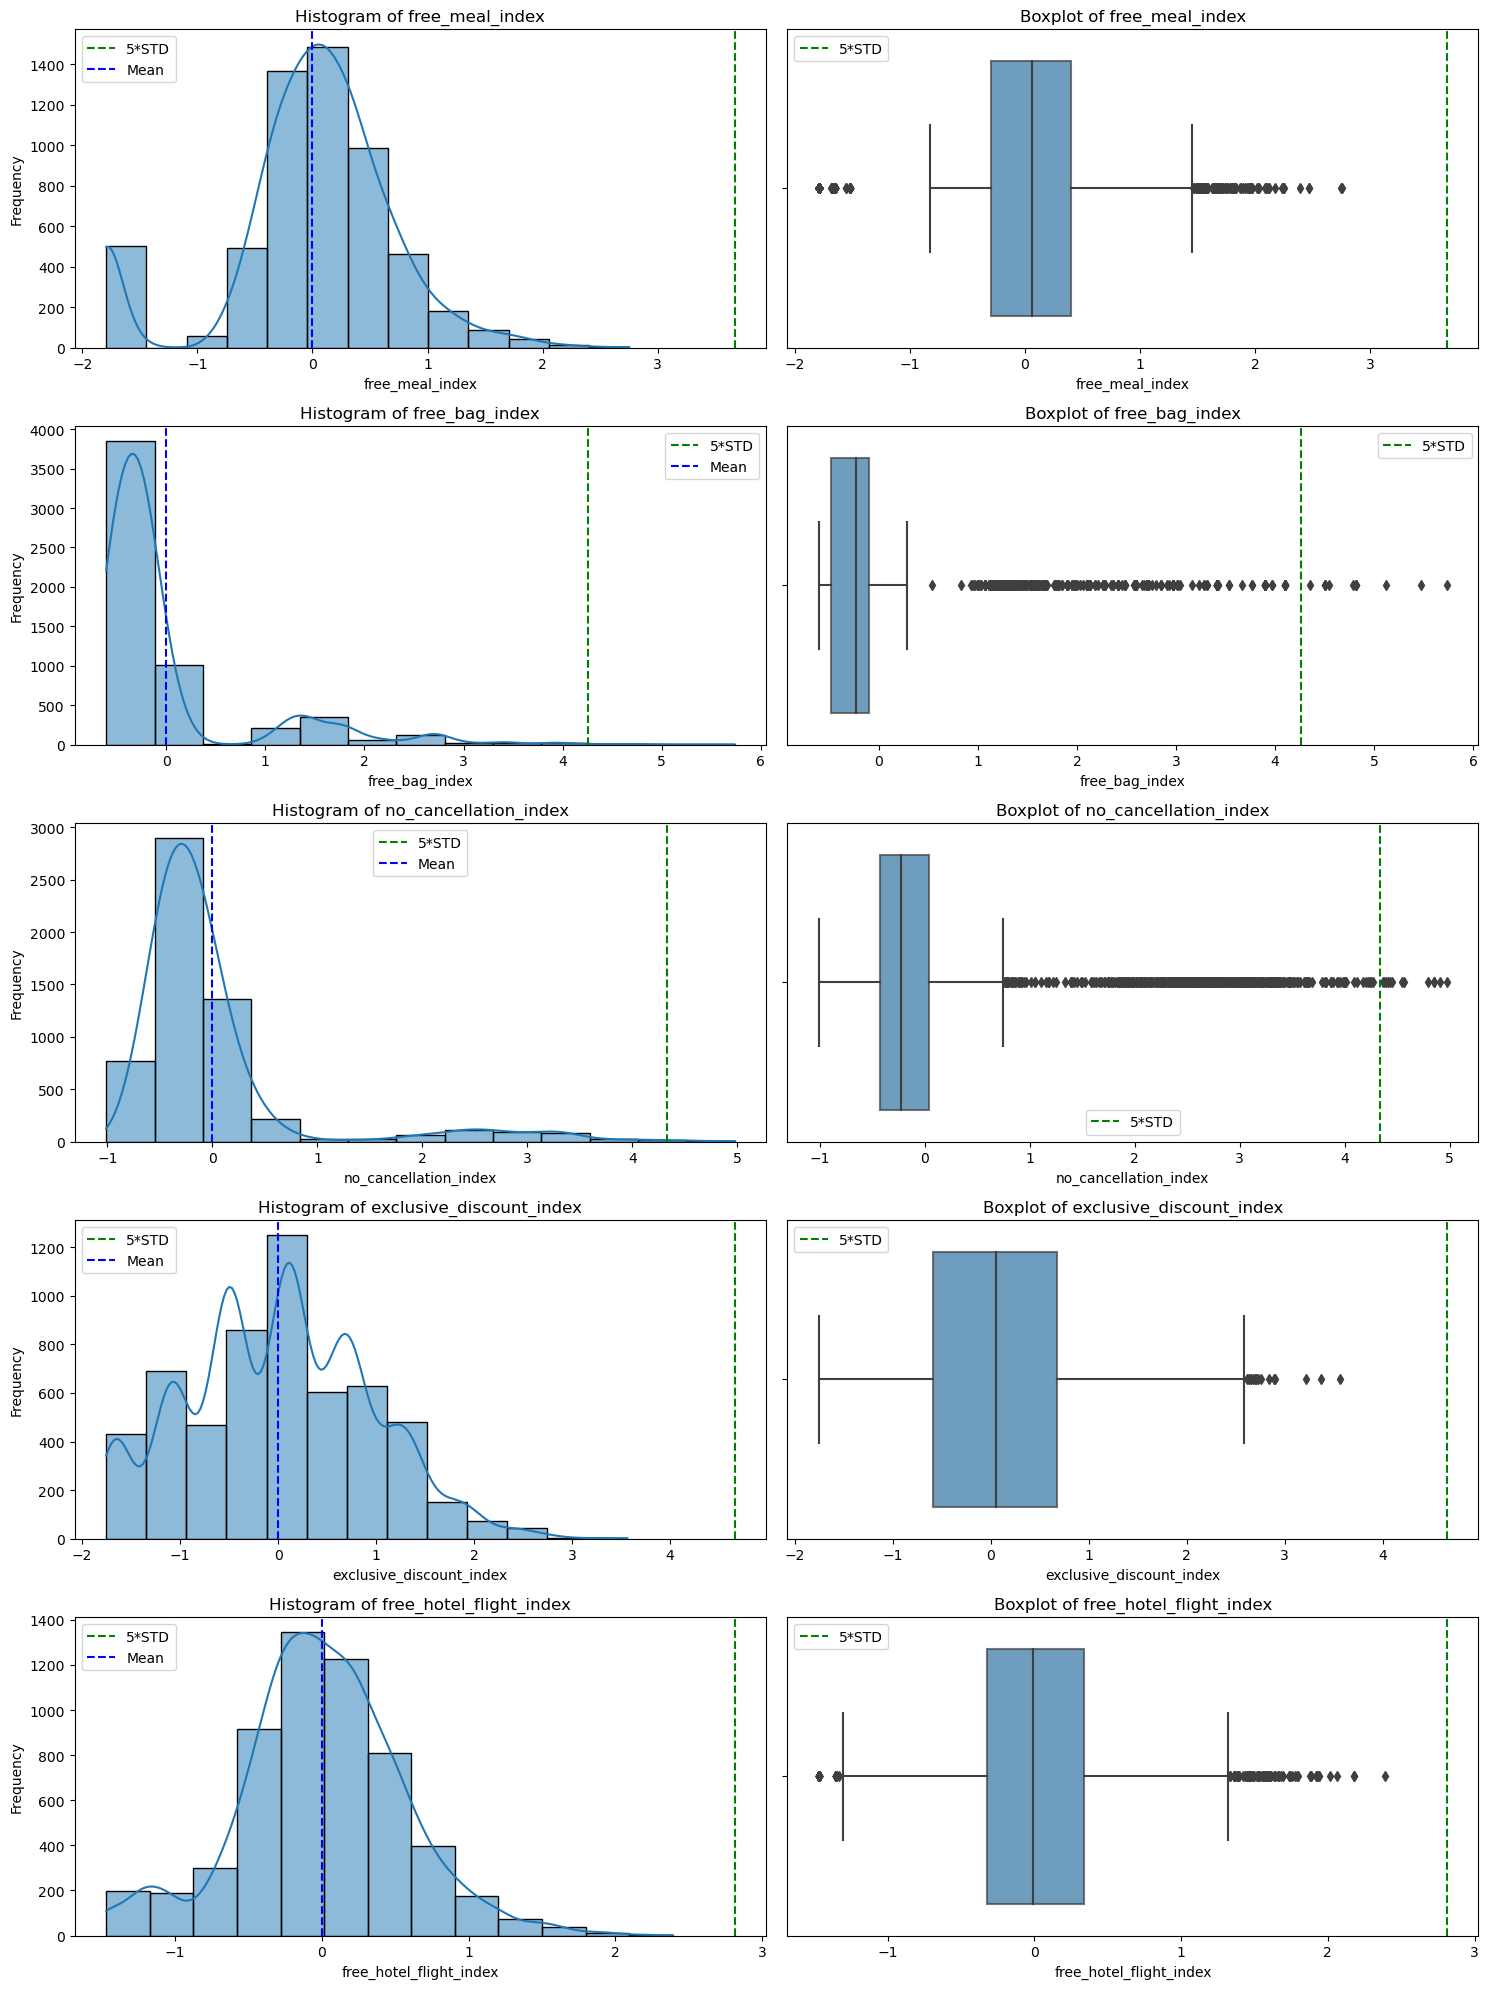

In [1651]:
# Set up the figure and axes
fig, axes = plt.subplots(len(indexes_columns), 2, figsize=(15, 4 * len(indexes_columns)))

for i, col in enumerate(indexes_columns):
    upper_bound = df[col].mean() + 5 * df[col].std()
    mean = df[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(indexes[col])) + 1)  # Sturges' formula
    sns.histplot(indexes[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD') # 5*STD line on boxplot
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=indexes[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    axes[i, 1].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD')  # 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [1652]:
# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = DataFrame()
rank_df['user_id'] = df['user_id']
rank_df.set_index('user_id', inplace=True)

# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'no_cancellation_index', 'exclusive_discount_index', 'free_hotel_flight_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = df.sort_values(by=[perk], ascending=False).reset_index(drop=True)
    
    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1
    
    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']

    
# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)
    
# Display the first few rows of the rank DataFrame
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,no_cancellation_index_rank,exclusive_discount_index_rank,free_hotel_flight_index_rank
0,181157,419,1638,348,1552,625
1,316527,2966,1574,2347,1790,1053
2,340166,4954,4969,5409,5250,1347
3,375729,3093,1075,2694,850,3754
4,385689,1443,802,4487,1274,729


In [1653]:
# Calculate the minimum rank for each customer and the corresponding perk index
rank_df['min_rank'] = rank_df.iloc[:, 1:].min(axis=1)
rank_df['best_index'] = rank_df.iloc[:, 1:].idxmin(axis=1).str.replace('_rank', '')

# Display the first few rows of the rank DataFrame with the min rank and best perk
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,no_cancellation_index_rank,exclusive_discount_index_rank,free_hotel_flight_index_rank,min_rank,best_index
0,181157,419,1638,348,1552,625,348,no_cancellation_index
1,316527,2966,1574,2347,1790,1053,1053,free_hotel_flight_index
2,340166,4954,4969,5409,5250,1347,1347,free_hotel_flight_index
3,375729,3093,1075,2694,850,3754,850,exclusive_discount_index
4,385689,1443,802,4487,1274,729,729,free_hotel_flight_index


Two new columns added:
- min_rank: Indicates the minimum rank among all the perks for each customer.
- best_index: Indicates the perk corresponding to the minimum rank.

The perk listed in best_perk is the one to which the customer most belongs

In [1654]:
# Count the number of customers most inclined towards each perk
perk_distribution = rank_df['best_index'].value_counts().reset_index()
perk_distribution.columns = ['Best Index', 'Number of Customers']

# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'no_cancellation_index': 'No cancellation fees',
    'exclusive_discount_index': 'Exclusive discounts',
    'free_hotel_flight_index': '1 night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Reorder columns for better readability
perk_distribution = perk_distribution[['Best Index', 'Perk Name', 'Number of Customers']]

# Display the updated distribution with perk names
perk_distribution

,Best Index,Perk Name,Number of Customers
0,no_cancellation_index,No cancellation fees,1435
1,free_hotel_flight_index,1 night free hotel with a flight,1309
2,free_bag_index,Free checked bag,1085
3,exclusive_discount_index,Exclusive discounts,1042
4,free_meal_index,Free hotel meal,811


In [1655]:
# Map the index names to the more descriptive perk names for segment labels
rank_df['segment_label'] = rank_df['best_index'].map(perk_names)

# Drop the 'best_index' column as we now have 'segment_label'
rank_df.drop(columns=['best_index'], inplace=True)

# Perform the join based on user_id
df = df.merge(rank_df[['user_id', 'segment_label']], on='user_id', how='left')

df.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration,...,free_bag_index,no_cancellation_index,exclusive_discount_index,weekend_hotel_rooms,scaled_weekend_hotel_rooms,free_hotel_flight_index,segment_label_x,kmeans_labels,handpicked_segment,segment_label_y
0,181157,2022-05-15,53,F,True,False,usa,houston,10,1.90,...,-0.098933,2.143,0.626,0.00,-0.362332,0.648,No cancellation fees,4,no_cancellation_index,No cancellation fees
1,316527,2022-09-08,41,F,True,True,canada,winnipeg,11,1.55,...,-0.098933,-0.144,0.520,0.00,-0.362332,0.462,Free checked bag,0,free_bag_index,1 night free hotel with a flight
2,340166,2022-09-27,50,M,True,True,usa,san francisco,11,0.55,...,-0.604933,-0.684,-1.294,0.00,-0.362332,0.362,Exclusive discounts,2,exclusive_discount_index,1 night free hotel with a flight
3,375729,2022-10-23,52,F,False,False,usa,atlanta,12,1.50,...,0.029067,-0.201,0.990,0.00,-0.362332,-0.206,No cancellation fees,0,exclusive_discount_index,Exclusive discounts
4,385689,2022-10-29,48,F,False,True,usa,nashville,11,1.09,...,1.113913,-0.468,0.736,0.24,1.284783,0.590,1 night free hotel with a flight,1,free_hotel_flight_index,1 night free hotel with a flight


### K-Means Clustering for Validation

In [1656]:
from sklearn.cluster import KMeans

# Selecting the features handpicked for each segment
#features_free_meal = ['scaled_age', 'scaled_has_children', 'scaled_avg_hotel_rooms', 'scaled_avg_checked_bags']
#features_free_bag = ['scaled_total_flights_booked', 'scaled_avg_stay_duration_day', 'scaled_has_children', 'scaled_avg_checked_bags']
#features_no_cancellation = ['scaled_cancellation_proportion', 'scaled_conversion_rate', 'scaled_age']
#features_exclusive_discounts = ['scaled_conversion_rate', 'scaled_avg_page_clicks', 'scaled_discounted_hotel_proportion', 'scaled_avg_flight_price_usd', 'scaled_married']
#features_free_hotel_flight = ['scaled_conversion_rate', 'scaled_total_flights_booked', 'scaled_avg_stay_duration_day', 'scaled_avg_hotel_rooms', 'scaled_avg_hotel_price_usd']

# Combining all the features
#all_selected_features = features_free_meal + features_free_bag + features_no_cancellation + features_exclusive_discounts + features_free_hotel_flight
# Remove duplicate features
#all_selected_features = list(set(all_selected_features))

# Extracting the relevant data from the original DataFrame
#X = df[all_selected_features]

# Select the scaled columns for clustering
scaled_columns = [col for col in df.columns if 'scaled_' in col]
X = df[scaled_columns]

# Run K-means clustering
kmeans = KMeans(n_clusters=5, init='k-means++', n_init= 10, max_iter=500, tol=0.00001, algorithm='elkan',random_state=0)  # Assuming 5 segments identified
kmeans_labels = kmeans.fit_predict(X)

# Add the cluster labels back to the original DataFrame
df['kmeans_labels'] = kmeans_labels

df['kmeans_labels'].value_counts()

2    2506
0    1771
1     560
3     435
4     410
Name: kmeans_labels, dtype: int64

In [1657]:
# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Convert to DataFrame for easier interpretation
df_centers = pd.DataFrame(cluster_centers, columns=scaled_columns)

# You can round the values for easier interpretation
df_centers = df_centers.round(2)

df_centers


,scaled_age,scaled_married,scaled_has_children,scaled_session_count,scaled_avg_session_duration,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_cancellation_proportion,scaled_total_flights_booked,...,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_saved_per_km,scaled_avg_flight_distance_from_home_km,scaled_round_trips_proportion,scaled_weekend_trip_proportion,scaled_weekend_hotel_rooms
0,0.15,-0.02,-0.13,0.14,0.32,0.22,0.99,0.98,-0.26,0.94,...,0.04,0.05,-0.02,0.21,-0.04,-0.07,-0.10,0.38,-0.21,-0.21
1,0.10,0.04,-0.00,0.05,-0.03,-0.09,0.33,0.33,-0.25,0.39,...,-0.02,-0.01,-0.08,0.25,-0.27,0.06,-0.08,0.41,2.62,2.54
2,-0.08,0.03,0.09,-0.14,-0.38,-0.41,-0.52,-0.51,-0.27,-0.56,...,0.00,-0.03,-0.08,0.18,0.26,0.02,-0.03,-0.01,-0.38,-0.36
3,-0.27,-0.10,-0.01,-0.18,-0.81,-0.79,-1.78,-1.81,-0.27,-1.53,...,-0.16,-0.06,-0.09,-2.35,-1.22,-0.12,-0.12,-2.31,-0.38,-0.36
4,-0.02,-0.05,-0.01,0.36,1.88,2.55,0.41,0.34,3.32,0.45,...,0.01,0.04,0.83,0.16,0.26,0.18,0.80,0.27,0.05,0.03


In [1658]:
# Convert cluster centers to a DataFrame
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_columns)

# Transpose for easier analysis
cluster_centers_df = cluster_centers_df.T

# Rename columns for clarity
cluster_centers_df.columns = [f'Cluster_{i}' for i in range(kmeans.n_clusters)]

# Sort each column to find the top and bottom features for each cluster
for col in cluster_centers_df.columns:
    print(f"Key features for {col}:")
    print(cluster_centers_df[col].sort_values(ascending=False))
    print("\n")

Key features for Cluster_0:
scaled_total_trips                         0.988972
scaled_conversion_rate                     0.978346
scaled_total_hotels_booked                 0.951180
scaled_total_flights_booked                0.943224
scaled_round_trips_proportion              0.375663
scaled_avg_session_duration                0.318927
scaled_avg_flight_seats                    0.296567
scaled_avg_page_clicks                     0.215494
scaled_avg_hotel_rooms                     0.206719
scaled_avg_checked_bags                    0.196787
scaled_age                                 0.148814
scaled_session_count                       0.143077
scaled_avg_hotel_discount_amount           0.049108
scaled_avg_hotel_price_usd                 0.037397
scaled_discounted_hotel_proportion        -0.015088
scaled_married                            -0.016302
scaled_avg_stay_duration_day              -0.038402
scaled_avg_flight_discount_amount         -0.063608
scaled_avg_saved_per_km             

It looks like the K-means clustering resulted in three larger groupings (Cluster 0 at 1789 and Cluster 1 at 1627 and Cluster 2 at 1284 users) and two relatively smaller groupings (Cluster 4 with 506 users and Cluster 3 with 430 users).

## Comparing Clusters with handpicked segments

In [1659]:
# Create a 'handpicked_segment' column by finding the column name of the max value among selected features
selected_features = ['free_meal_index', 'no_cancellation_index', 'free_hotel_flight_index', 'free_bag_index', 'exclusive_discount_index']
df['handpicked_segment'] = df[selected_features].idxmax(axis=1)


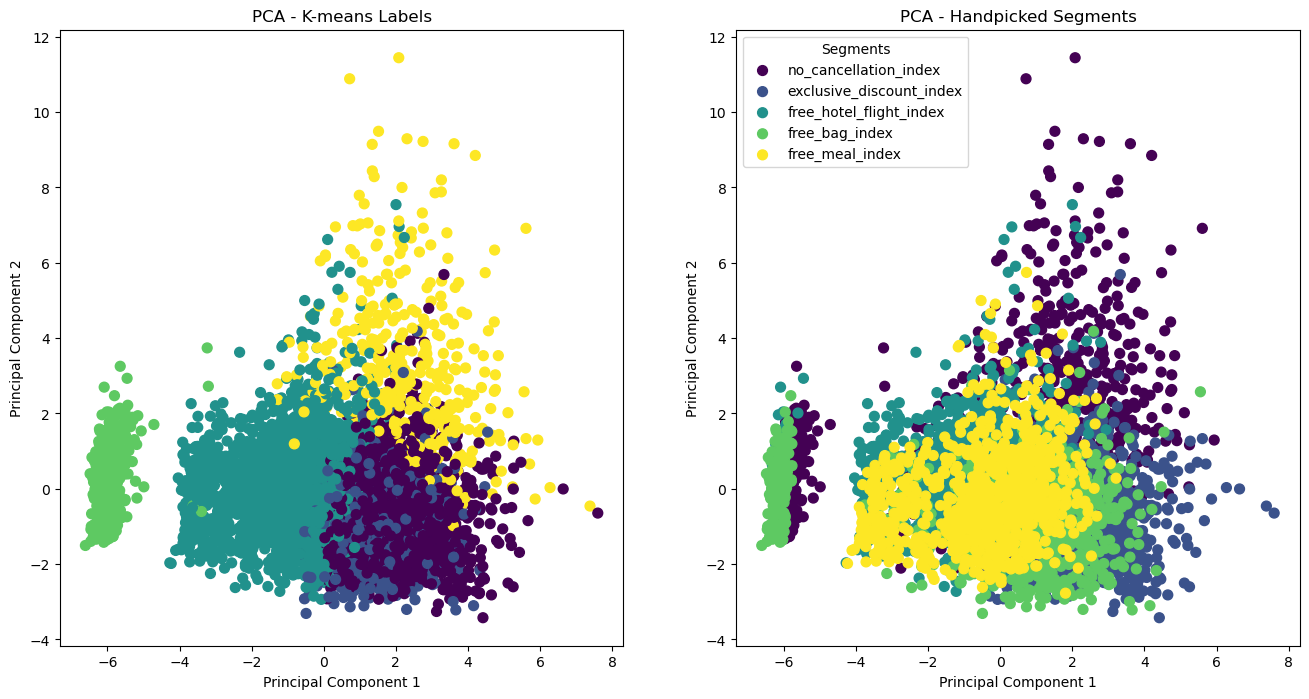

In [1660]:
# Select scaled features and clustering labels for PCA
scaled_columns = [col for col in df.columns if 'scaled_' in col]
label_columns = ['kmeans_labels', 'handpicked_segment']

# Create a new DataFrame containing only the relevant columns
df_pca = df[scaled_columns + label_columns]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_pca[scaled_columns])

# Apply PCA and reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df_principal = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Add back the clustering labels
df_principal['kmeans_labels'] = df_pca['kmeans_labels']
df_principal['handpicked_segment'] = df_pca['handpicked_segment']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means labels
ax[0].scatter(df_principal['Principal Component 1'], df_principal['Principal Component 2'],
              c=df_principal['kmeans_labels'], cmap='viridis', s=50)
ax[0].set_title('PCA - K-means Labels')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Handpicked labels
unique_segments = df_principal['handpicked_segment'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_segments)))

for i, segment in enumerate(unique_segments):
    filtered_data = df_principal[df_principal['handpicked_segment'] == segment]
    ax[1].scatter(filtered_data['Principal Component 1'], filtered_data['Principal Component 2'],
                  c=[colors[i]] * len(filtered_data), label=segment, s=50)

ax[1].set_title('PCA - Handpicked Segments')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].legend(title='Segments')

plt.show()


In [1623]:
scaled_columns = [col for col in df.columns if 'scaled_' in col]
kmeans_scaled_means = df.groupby('kmeans_labels')[scaled_columns].mean().round(2).T

kmeans_scaled_means

kmeans_labels,0,1,2,3,4
scaled_age,0.15,0.10,-0.08,-0.27,-0.02
scaled_married,-0.02,0.04,0.03,-0.10,-0.05
scaled_has_children,-0.13,-0.00,0.09,-0.01,-0.01
scaled_session_count,0.14,0.05,-0.14,-0.18,0.36
scaled_avg_session_duration,0.32,-0.03,-0.38,-0.81,1.88
scaled_avg_page_clicks,0.22,-0.09,-0.41,-0.79,2.55
scaled_total_trips,0.99,0.33,-0.52,-1.78,0.41
scaled_conversion_rate,0.98,0.33,-0.51,-1.81,0.34
scaled_cancellation_proportion,-0.26,-0.25,-0.27,-0.27,3.32
scaled_total_flights_booked,0.94,0.39,-0.56,-1.53,0.45


In [1624]:
df.groupby('handpicked_segment').mean(numeric_only=True).round(2).T

scaled_columns = [col for col in df.columns if 'scaled_' in col]
handpicked_scaled_means = df.groupby('handpicked_segment')[scaled_columns].mean().round(2).T

handpicked_scaled_means

handpicked_segment,exclusive_discount_index,free_bag_index,free_hotel_flight_index,free_meal_index,no_cancellation_index
scaled_age,-0.14,0.02,-0.01,0.01,0.35
scaled_married,-0.06,0.18,-0.03,-0.16,0.13
scaled_has_children,-0.33,1.03,-0.13,-0.50,-0.36
scaled_session_count,-0.05,-0.04,0.10,-0.03,0.21
scaled_avg_session_duration,-0.50,-0.28,-0.02,0.84,0.27
scaled_avg_page_clicks,-0.51,-0.32,-0.07,0.67,0.85
scaled_total_trips,-0.68,-0.12,0.42,0.77,-0.02
scaled_conversion_rate,-0.69,-0.12,0.41,0.78,-0.06
scaled_cancellation_proportion,-0.27,-0.27,-0.21,-0.02,1.72
scaled_total_flights_booked,-0.66,-0.11,0.44,0.70,-0.03


In [1625]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
score = silhouette_score(X, kmeans_labels)

score

0.12557522276696878

Given the low silhouette score and the business knowledge in engineering the handpicked features, we will go with the handpicked features over the K-means clustering. 

### Segment Analysis

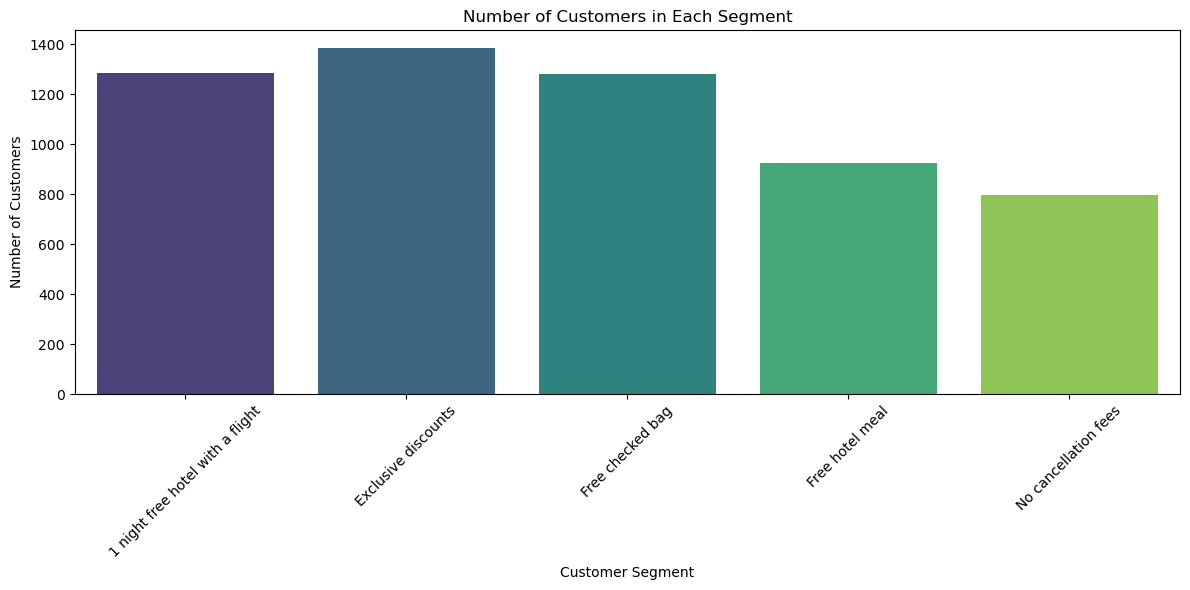

In [1626]:
# Count the number of customers in each segment
segment_counts = df['segment_label'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

plt.title('Number of Customers in Each Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

1. Diverse Preferences: The segments show a variety of customer preferences, from those who value free meals in hotels to those who prioritize flexibility with no cancellation fees.
2. Size Disparity: The segments aren't evenly sized. "1 night free hotel with a flight" and "No cancellation fees" seem to attract more users, while "Exclusive discounts" is the smallest group. This could suggest different levels of appeal for these features.
3. Promotion Opportunities: Larger segments like "Free hotel meal" and "No cancellation fees" might represent popular incentives that could be further marketed.

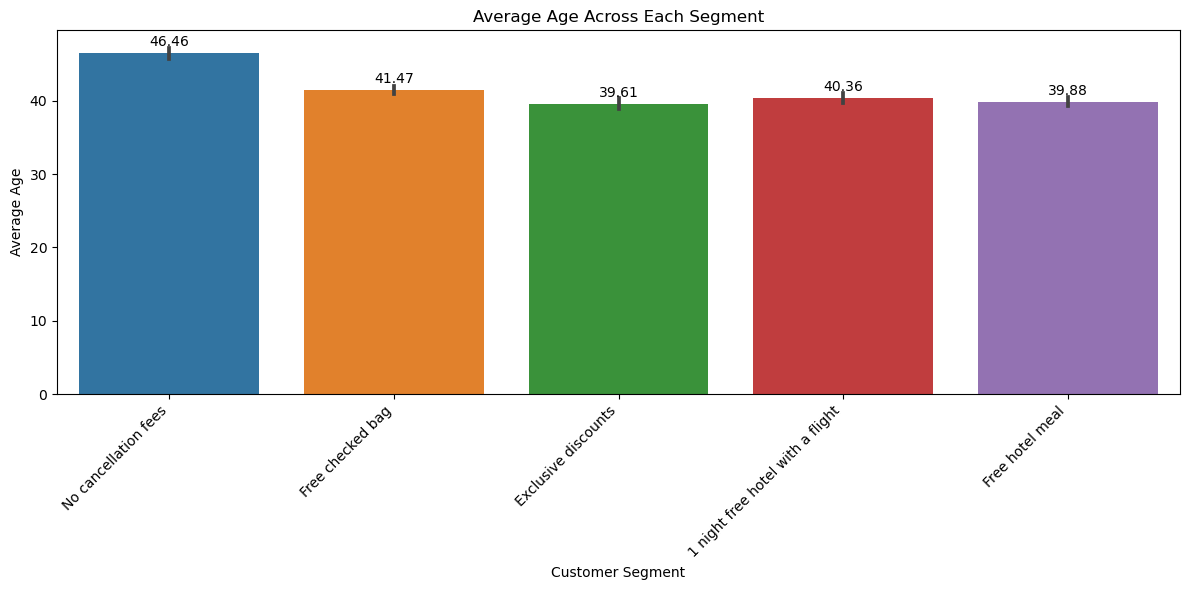

In [1627]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='segment_label', y='age', data=df, estimator=lambda x: sum(x) / len(x))
plt.title('Average Age Across Each Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Age')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the actual value
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [1628]:
avg_age_by_segment = df.groupby('segment_label')['age'].mean().reset_index()
avg_age_by_segment

,segment_label,age
0,1 night free hotel with a flight,40.364697
1,Exclusive discounts,39.611391
2,Free checked bag,41.466875
3,Free hotel meal,39.875944
4,No cancellation fees,46.464330


1. Age Skew:
- The "Free hotel meal" segment has a noticeably higher average age (~49 years), suggesting this feature might be more appealing to an older demographic.
- On the flip side, the "Free checked bag" and "No cancellation fees" segments have younger average ages (~37 years), indicating these features might attract a younger crowd.
2. Targeted Marketing:
- Understanding these age dynamics can inform targeted marketing strategies. For example, promotions for "Free hotel meals" could be aimed at platforms frequented by older demographics.
3. Product Development:
- The younger demographics preferring "Free checked bag" and "No cancellation fees" might indicate a desire for flexibility and convenience, which could inform future product offerings.
4. Cross-Sell Opportunities:
- Given that different age groups prefer different features, there might be cross-sell or up-sell opportunities. For example, younger users in the "No cancellation fees" segment might be interested to try "Exclusive discounts."

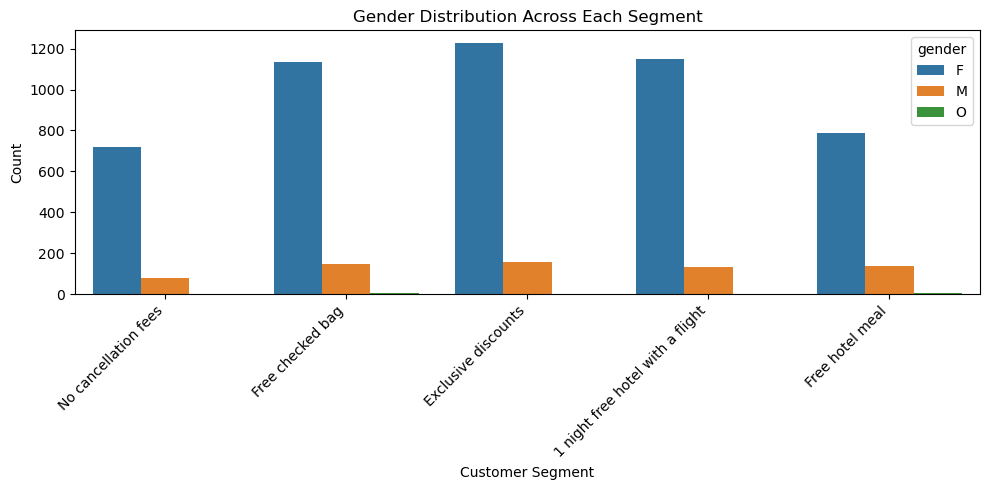

In [1629]:
plt.figure(figsize=(10, 5))
sns.countplot(x='segment_label', hue='gender', data=df)
plt.title('Gender Distribution Across Each Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1630]:
gender_distribution_by_segment = df.groupby(['segment_label', 'gender']).size().unstack(fill_value=0).reset_index()
gender_distribution_by_segment

gender,segment_label,F,M,O
0,1 night free hotel with a flight,1151,133,2
1,Exclusive discounts,1228,158,1
2,Free checked bag,1133,147,3
3,Free hotel meal,787,136,4
4,No cancellation fees,719,80,0


1. Gender Imbalance:
- The Female category is significantly larger in all segments. This could mean the features or marketing are particularly appealing to females.
2. Variability with Males:
- The number of males does not vary significantly across segments, though the lowest representation is in No cancellation fees. 
3. Highest Female Preference:
- The "Exclusive discount segment has the highest female representation, suggesting these features might be especially appealing to females.

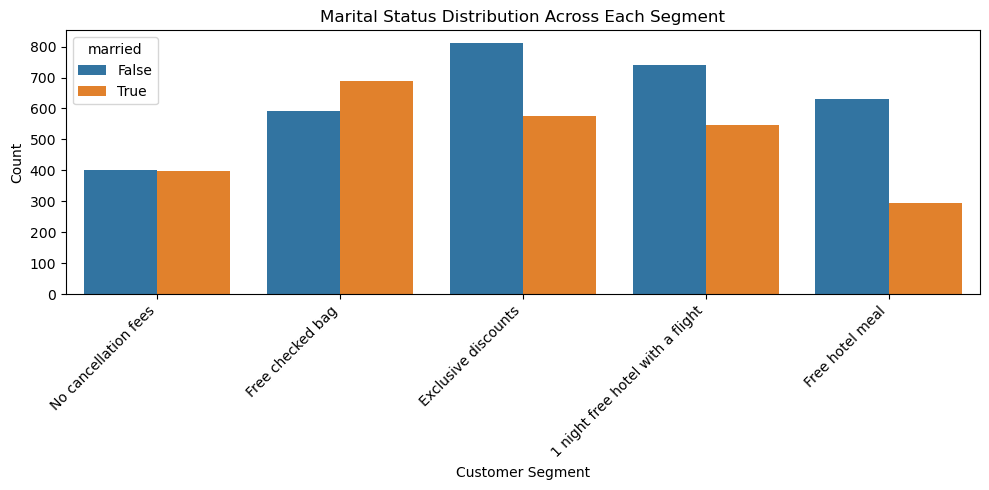

In [1631]:
plt.figure(figsize=(10, 5))
sns.countplot(x='segment_label', hue='married', data=df)
plt.title('Marital Status Distribution Across Each Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1632]:
marriage_distribution_by_segment = df.groupby(['segment_label', 'married']).size().unstack(fill_value=0).reset_index()
marriage_distribution_by_segment

married,segment_label,False,True
0,1 night free hotel with a flight,739,547
1,Exclusive discounts,812,575
2,Free checked bag,593,690
3,Free hotel meal,631,296
4,No cancellation fees,400,399


1. Significant Variability:
- The distribution of married and unmarried individuals varies notably across segments. This could be indicative of the appeal of certain features to different life stages or lifestyles.
2. Marriage Attraction:
- The "Free hotel meal" segment stands out with a significantly higher number of married individuals. This could imply that this feature is more attractive to couples or families.
3. Unmarried Majority:
- Except for the "Free hotel meal" segment, all other segments have a higher number of unmarried individuals. This might suggest that these features are generally more appealing to singles or those not in a marital relationship.
4. Balanced Appeal:
- The "Exclusive discounts" segment has a more balanced distribution between married and unmarried individuals compared to other segments. This might suggest a universal appeal of this feature.

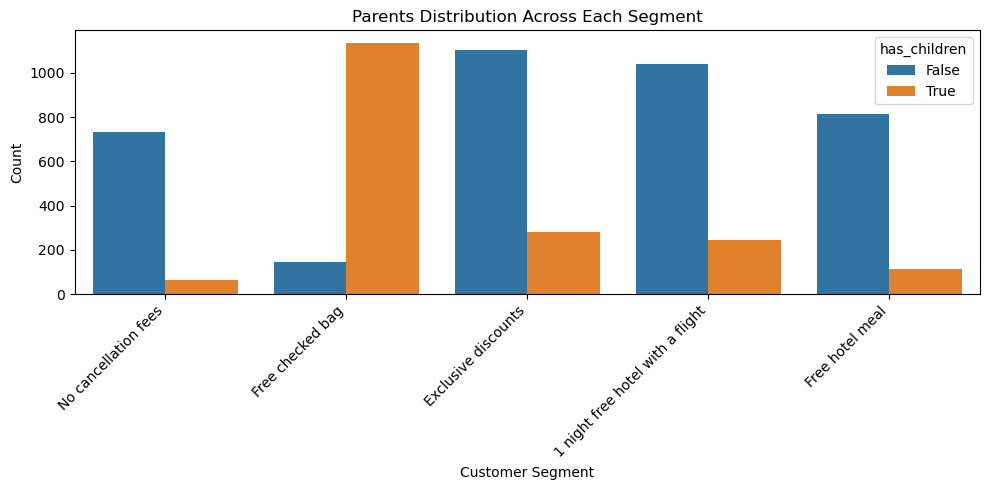

In [1633]:
plt.figure(figsize=(10, 5))
sns.countplot(x='segment_label', hue='has_children', data=df)
plt.title('Parents Distribution Across Each Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1634]:
children_distribution_by_segment = df.groupby(['segment_label', 'has_children']).size().unstack(fill_value=0).reset_index()
children_distribution_by_segment


has_children,segment_label,False,True
0,1 night free hotel with a flight,1041,245
1,Exclusive discounts,1105,282
2,Free checked bag,147,1136
3,Free hotel meal,815,112
4,No cancellation fees,733,66


1. Family Focus:
- The "Free checked bag" segment has a notably higher number of individuals with children. This suggests the feature is extremely popular among families, which aligns with the higher number of married individuals in this segment.
2. Mostly Child-Free:
- Segments like "1 night free hotel with a flight," "Exclusive discounts," and "No cancellation fees" are predominantly populated by individuals without children. This could indicate these features are more appealing to singles or couples without kids.

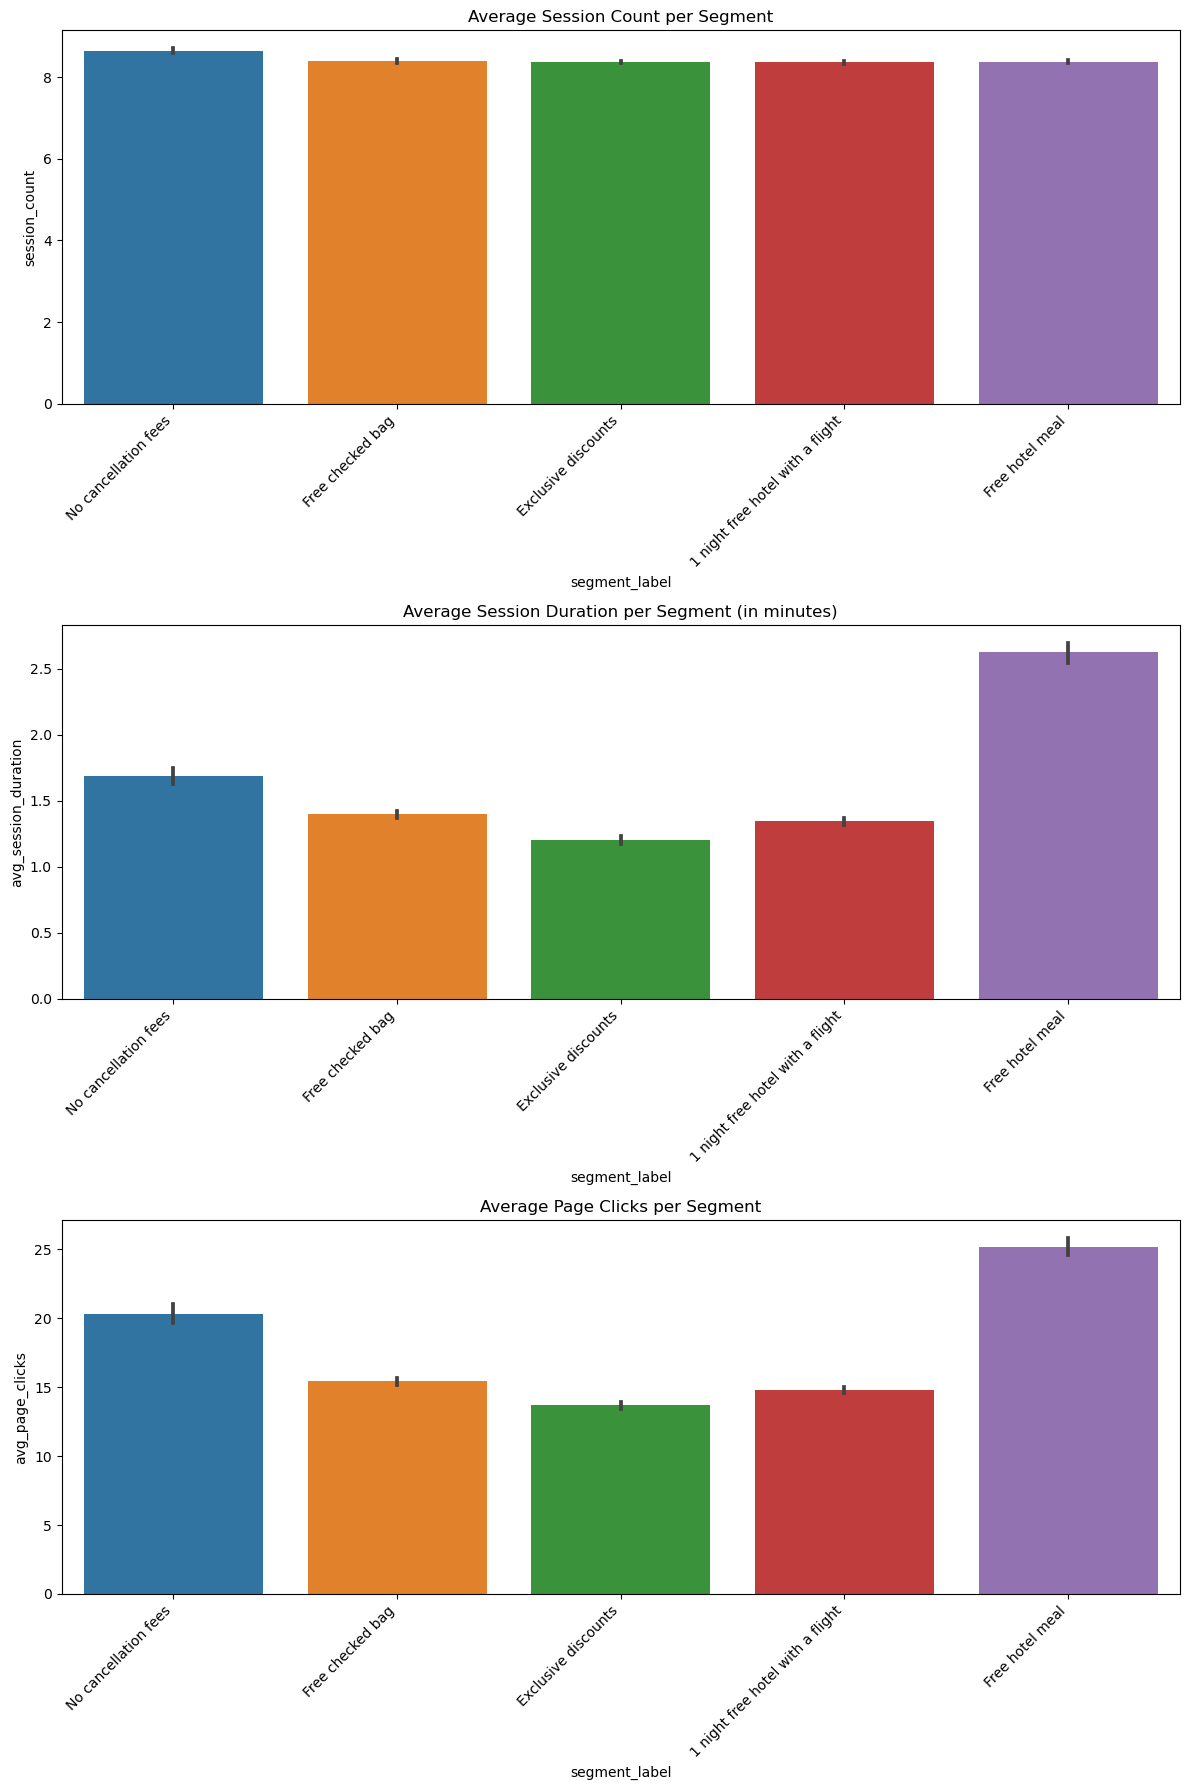

In [1635]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Unique segment labels
unique_segments = df['segment_label'].unique()

sns.barplot(x='segment_label', y='session_count', data=df, ax=axs[0])
axs[0].set_title('Average Session Count per Segment')
axs[0].set_xticklabels(unique_segments, rotation=45, ha='right')

sns.barplot(x='segment_label', y='avg_session_duration', data=df, ax=axs[1])
axs[1].set_title('Average Session Duration per Segment (in minutes)')
axs[1].set_xticklabels(unique_segments, rotation=45, ha='right')

sns.barplot(x='segment_label', y='avg_page_clicks', data=df, ax=axs[2])
axs[2].set_title('Average Page Clicks per Segment')
axs[2].set_xticklabels(unique_segments, rotation=45, ha='right')

plt.tight_layout()
plt.show()

- All segments have a similar average session count, ranging from around 8.3 to 8.8.
- free hotel meal has a higher session duration over ~2 minutes.
- Free hotel meal has a higher average page clicks well over ~20. 
- Both average session duration and average page clicks have similar engagement across all segments. 

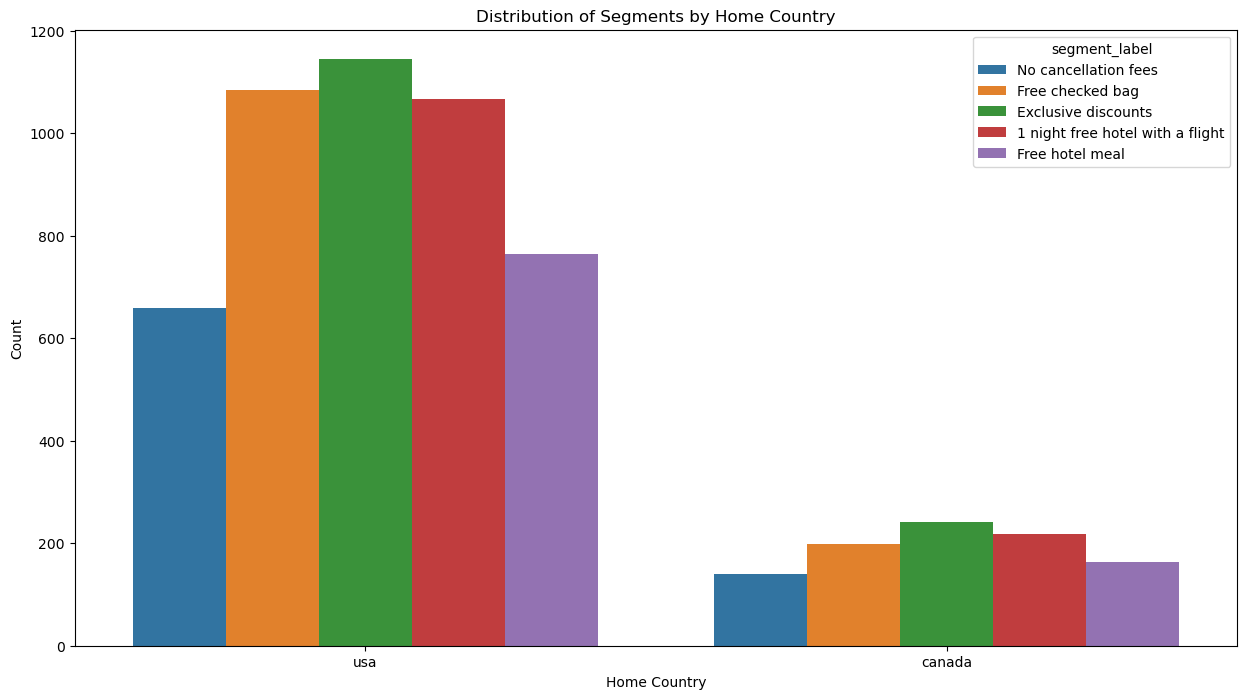

In [1636]:
# For Country
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='home_country', hue='segment_label')
plt.title('Distribution of Segments by Home Country')
plt.xlabel('Home Country')
plt.ylabel('Count')
#plt.xticks(rotation=45)
plt.show()

- Both USA and Canada has an interest in Exclusive discounts.

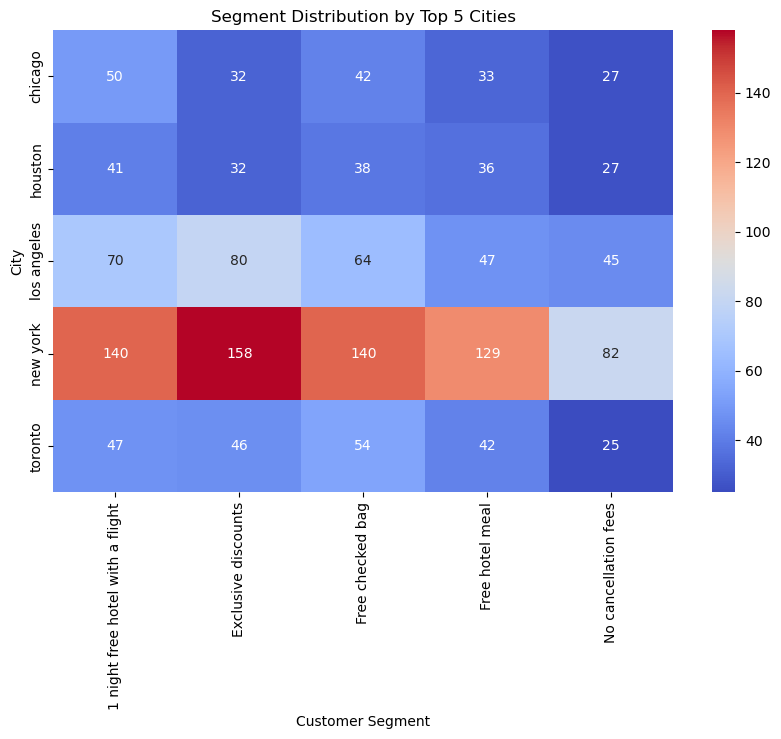

In [1637]:
# Plotting the distribution of customers across top 5 cities and their most preferred perk
top_5_cities = df['home_city'].value_counts().nlargest(5).index.tolist()

# Filter the data to only include the top 5 cities
top_5_cities_data = df[df['home_city'].isin(top_5_cities)]

# Creating a pivot table
pivot_table = pd.pivot_table(top_5_cities_data, values='user_id', index=['home_city'], columns=['segment_label'], aggfunc='count', fill_value=0)

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Segment Distribution by Top 5 Cities')
plt.xlabel('Customer Segment')
plt.ylabel('City')
plt.show()

- Among the top 5 cities, NYC is the leader in all segments, particularly within No cancellation fees and 1 night free hotel with a flight. 

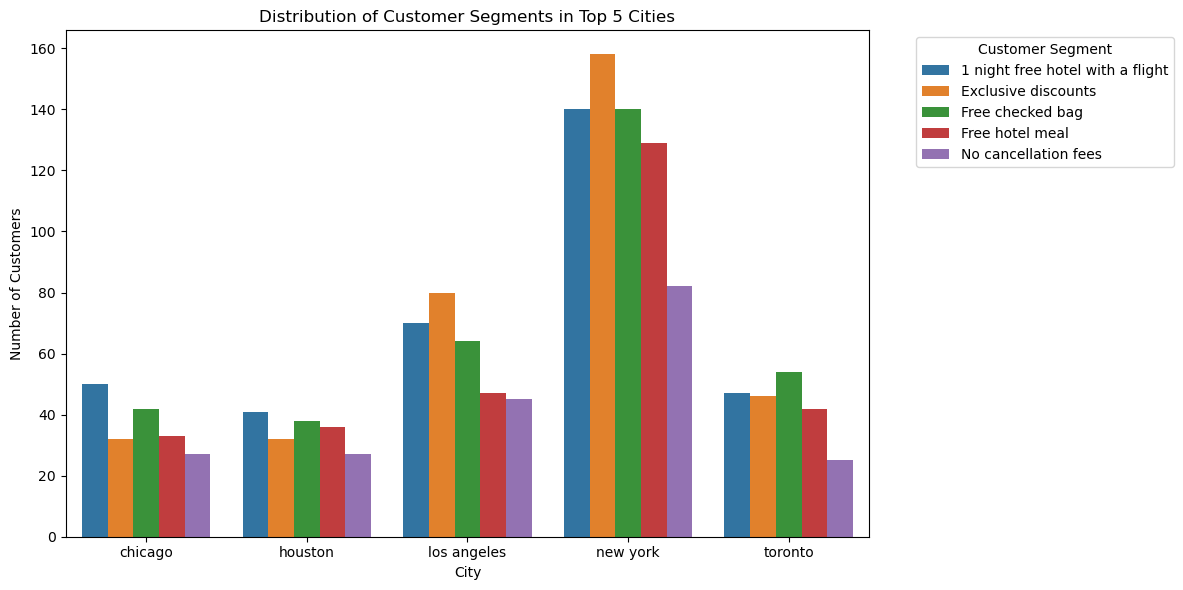

In [1638]:
# Filter to only include top 5 cities
top_5_cities = df['home_city'].value_counts().nlargest(5).index
df_top_5 = df[df['home_city'].isin(top_5_cities)]

# Group by city and segment, then count the number of customers
df_grouped = df_top_5.groupby(['home_city', 'segment_label']).size().reset_index(name='Count')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='home_city', y='Count', hue='segment_label', data=df_grouped)
plt.title('Distribution of Customer Segments in Top 5 Cities')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Across all of the top 5 cities, we can see a keen interest in Exclusive discounts especially in New York and LA. Chicago would take advantage of 1 night free hotel with flight along with Houston. Toronto has a propensity to lean toward free checked bag. 

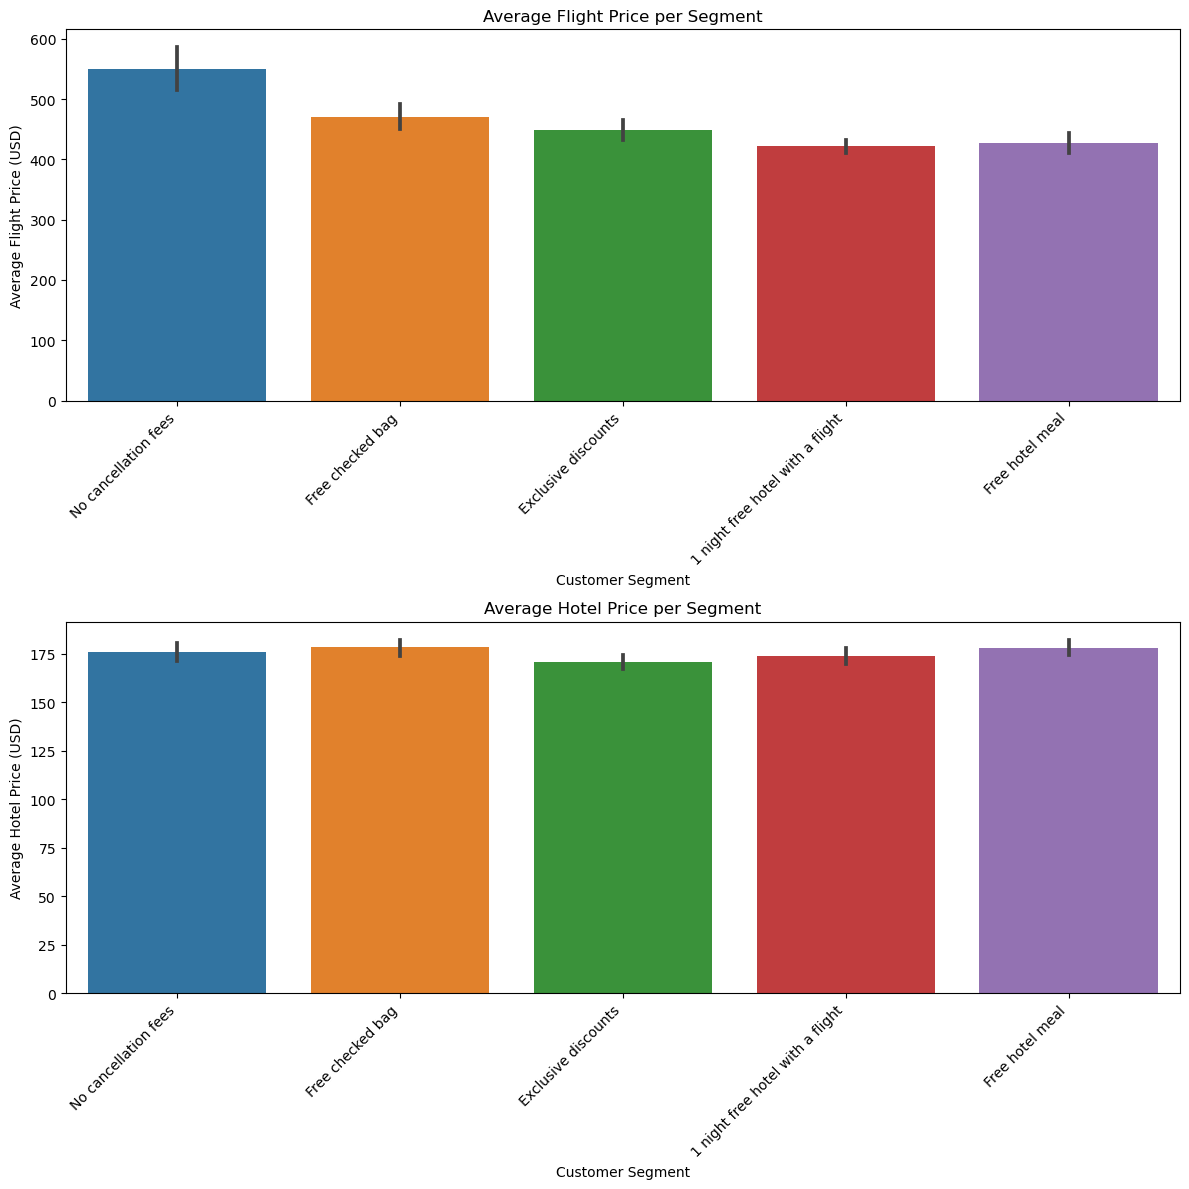

In [1639]:
# Create the bar plot
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(x='segment_label', y='avg_flight_price_usd', data=df, ax=axs[0])
axs[0].set_title('Average Flight Price per Segment')
axs[0].set_xlabel('Customer Segment')
axs[0].set_ylabel('Average Flight Price (USD)')
axs[0].set_xticklabels(df['segment_label'].unique(), rotation=45, ha='right')

sns.barplot(x='segment_label', y='avg_hotel_price_usd', data=df, ax=axs[1])
axs[1].set_title('Average Hotel Price per Segment')
axs[1].set_xlabel('Customer Segment')
axs[1].set_ylabel('Average Hotel Price (USD)')
axs[1].set_xticklabels(df['segment_label'].unique(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

- Those who are most interested in Exclusive discounts tend to spend more per flight on average.
- Each segment on average spend the same when it comes to hotels. 

In [1640]:
finished_segmentation_df = df[['user_id','segment_label']]

# Display the first few rows of the final DataFrame
finished_segmentation_df.head()

,user_id,segment_label
0,181157,No cancellation fees
1,316527,Free checked bag
2,340166,Exclusive discounts
3,375729,No cancellation fees
4,385689,1 night free hotel with a flight


In [1641]:
# Save the DataFrame to a CSV file
finished_segmentation_df.to_csv('TravelTide_Customer_Segmentation.csv')